# Data Science Project Planning

## Data Description

### Player Data

Player data has 196 observations and 7 variables.

Player data has 196 observations and 7 variables: two numerical (played_hours, age), four character (experience, hashedEmail, name, gender), and one logical (subscribe).


Two numerical:

  + played_hours: total hours played by a player
  + Age: age of player

Four character:

  + experience: level of the player 
  + hashedEmail: anonymized email for privacy.
  + name: player's first name
  + gender: player's gender

One logical:

  + subscribe: whether the player is subscribed to game-related newsletter

Summary stats: Age [9–58], mean 21.1; Played Hours [0–223.1], mean 5.85. (See the Exploratory section for computation)

Potential Issues:
* Played hours measurement unclear (self-reported or tracked).
* Wide age range and self-reported experience may introduce bias.
* NA values could skew results.

### Sessions Data

The sessions data has 1535 observations and 5 variables.

Two numerical:

  + original_start_time and original_end_time: session start and end times in UNIX milliseconds.

Three character:

  + start_time and end_time: human-readable versions of the above.
  + hashedEmail links sessions to players.

Summary stats for the numerical timestamps are not meaningful without computing session durations.

Potential Issues:
* Unclear time zones across sessions.
* Missing or inconsistent start/end times.
* Multiple emails per player could fragment data.
* NA values could skew results.

## Questions

Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific Question: Can player characteristics (experience and age) predict total hours played in the player dataset?

Wrangling: To prepare for KNN, played_hours will be recoded as Low/Medium/High activity. Experience will be converted to a 1–5 scale and both predictors standardized. Only players.csv will be used, as sessions.csv focuses on timing rather than player traits.

## Exploratory Data Analysis and Visualization

In [7]:
library(tidyverse)
sessions <- read_csv("sessions.csv")
players <- read_csv("players.csv")


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
players <- rename(players, hashed_email = hashedEmail, age = Age) #variable names are all consistent

players_summary <- summarise(players,
  age_min = min(age, na.rm=TRUE),
  age_max = max(age, na.rm=TRUE),
  age_mean = mean(age, na.rm=TRUE),
  played_hours_min = min(played_hours, na.rm=TRUE),
  played_hours_max = max(played_hours, na.rm=TRUE),
  played_hours_mean = mean(played_hours, na.rm=TRUE)
)
players_summary

age_min,age_max,age_mean,played_hours_min,played_hours_max,played_hours_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,58,21.13918,0,223.1,5.845918


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


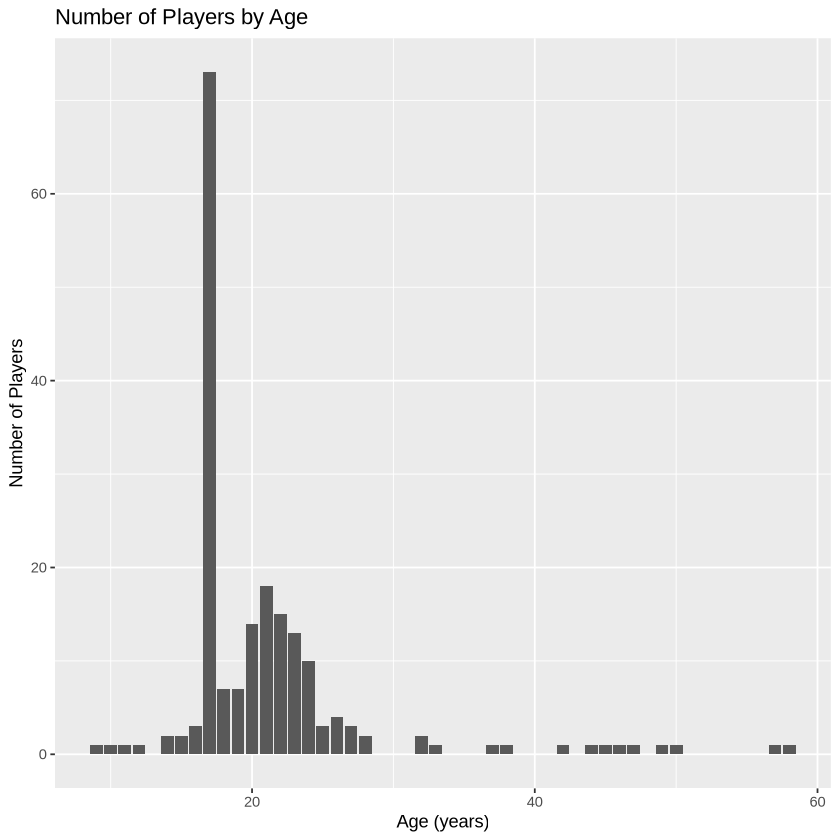

In [9]:
age_plot <- ggplot(players, aes(x = age)) +
  geom_bar() +
  labs(title = "Number of Players by Age", x = "Age (years)", y = "Number of Players")
age_plot

This plot shows that most players are between 15-30 years old, peaking at 17. This concentration is important for identifying which age groups to target for recruitment.

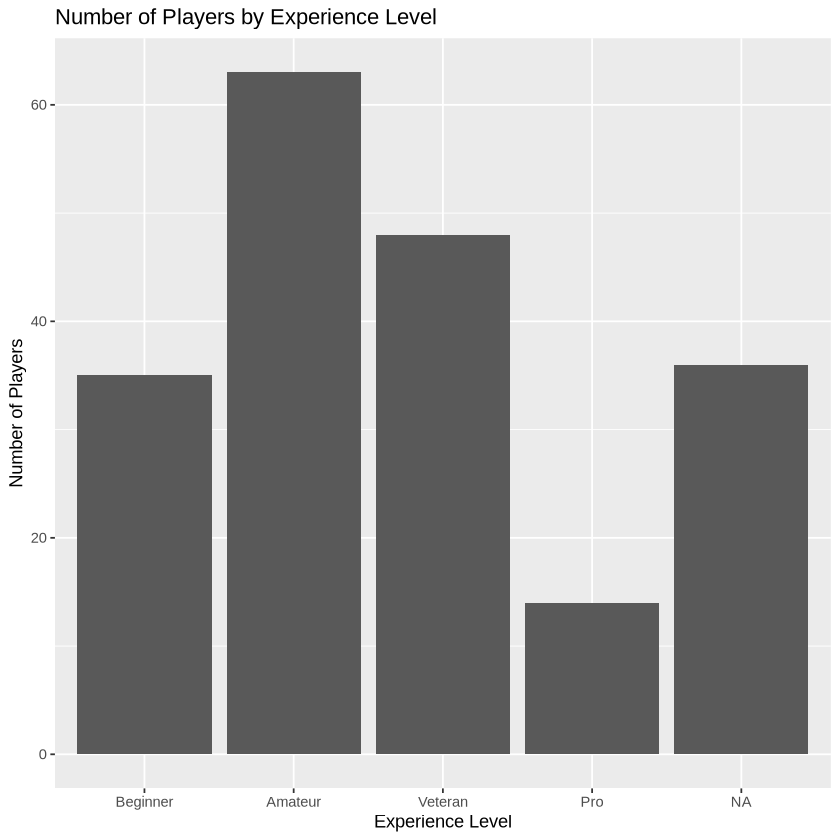

In [10]:
players_exp_order <- players |>
  mutate(experience = factor(experience, 
                             levels = c("Beginner", "Amateur", "Normal", "Veteran", "Pro")))

experience_plot <- ggplot(players_exp_order, aes(x = experience)) +
  geom_bar() +
  labs(title = "Number of Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players")
experience_plot

The large NA column likely reflects uncertain responses. Bars are ordered from least to most experienced, showing that amateurs contribute most to the data and that NAs should be addressed before classification.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


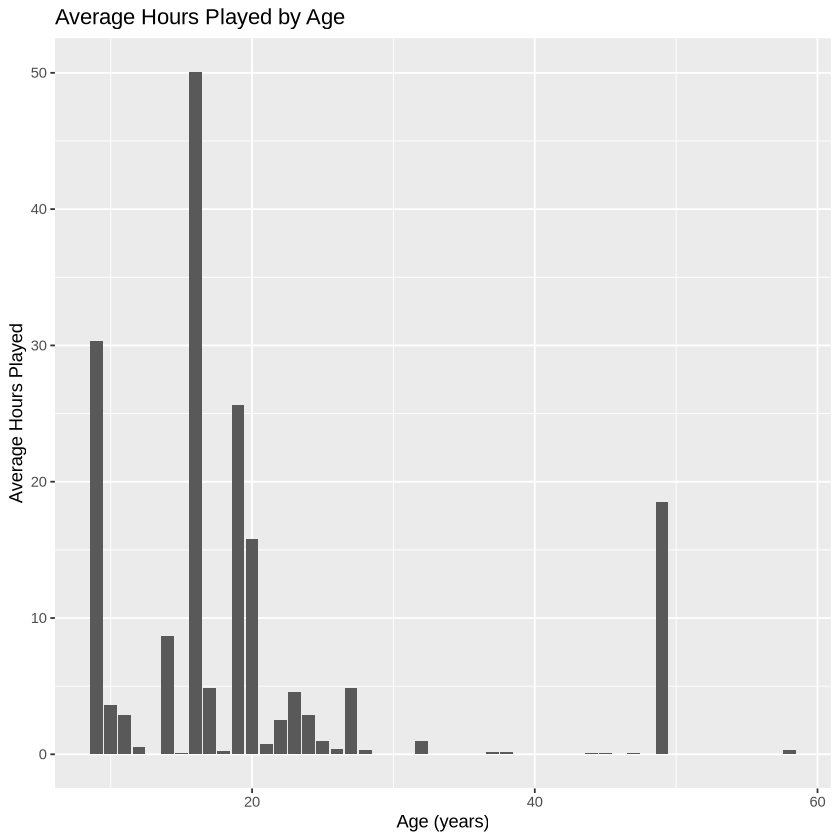

In [11]:
avg_plot <- players |>
            group_by(age) |>
            summarise(avg_hours = mean(played_hours, na.rm = TRUE)) |>
            ggplot(aes(x = age, y = avg_hours)) +
            geom_bar(stat="identity") +
            labs(title = "Average Hours Played by Age", x = "Age (years)", y = "Average Hours Played")
avg_plot

Average playtime also peaks around age 17, suggesting that teenagers are both the most active and most informative group for predicting player activity.

## Methods and Plan

I will use KNN classification to predict activity level (Low/Medium/High) from age and experience. It’s suitable for nonlinear relationships and assumes similar players have similar activity levels once standardized. KNN is sensitive to outliers, class imbalance, and k. The optimal k will be tuned with 5-fold cross-validation using accuracy and confusion matrices. Data will be split 70/30 into training and testing sets, with preprocessing done before splitting.